In [71]:
from functools import reduce
from pathlib import Path
from typing import List, Optional, Tuple

import torch
from decord import VideoReader, cpu
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import towhee

import torchmetrics as metrics

import ilids.towhee_utils.override.movinet
import ilids.towhee_utils.cached_video_decoder

In [72]:
ALL_MOVINET_MODELS = [
    "movineta0",
    "movineta1",
    "movineta2",
    "movineta3",
    "movineta4",
    "movineta5",
]

In [73]:
video_decoder = (
    towhee.glob["path"]("../data/sequences/*P_SZTR*.mp4")
    .video_decode.ffmpeg["path", "frames"]()
    .ilids.cached_video_decoder[("path", "frames"), "frames"]()
)

In [74]:
def movinet_classification(video_decoder, model_name: str) -> towhee.DataCollection:
    net_classification = video_decoder.ilids.movinet[
        "frames", ("labels", "scores", "features")
    ](model_name=model_name)

    th_df: towhee.DataFrame = net_classification.select[
        "path", "labels", "scores", "features"
    ]()

    return th_df.fill_entity(dict(model_name=model_name)).to_dc()

In [75]:
movinet_classification_dcs = [
    movinet_classification(video_decoder, model_name)
    for model_name in ALL_MOVINET_MODELS
]

In [76]:
joined_dc: towhee.DataCollection = reduce(
    lambda i, j: i + j, movinet_classification_dcs
)

In [77]:
label_score_df = pd.DataFrame(
    [
        dict(
            **{"class": "TP" in classification_entity.path},
            model_name=classification_entity.model_name,
            video=classification_entity.path,
            label=topk_label,
            score=topk_score
        )
        for classification_entity in joined_dc
        for topk_label, topk_score in zip(
            classification_entity.labels, classification_entity.scores
        )
    ]
)
label_score_df.head()

class model_name                                              video  \
0   True  movineta0  ../data/sequences/TP_SZTR_video_SZTRA202b13_00...   
1   True  movineta0  ../data/sequences/TP_SZTR_video_SZTRA202b13_00...   
2   True  movineta0  ../data/sequences/TP_SZTR_video_SZTRA202b13_00...   
3   True  movineta0  ../data/sequences/TP_SZTR_video_SZTRA202b13_00...   
4   True  movineta0  ../data/sequences/TP_SZTR_video_SZTRA202b13_00...   

                  label    score  
0        stretching arm  0.46761  
1        stretching leg  0.28643  
2                  yoga  0.03495  
3          bending back  0.01487  
4  using a paint roller  0.01195

In [78]:
VIDEOS = label_score_df.sort_values(by="class")["video"].unique()

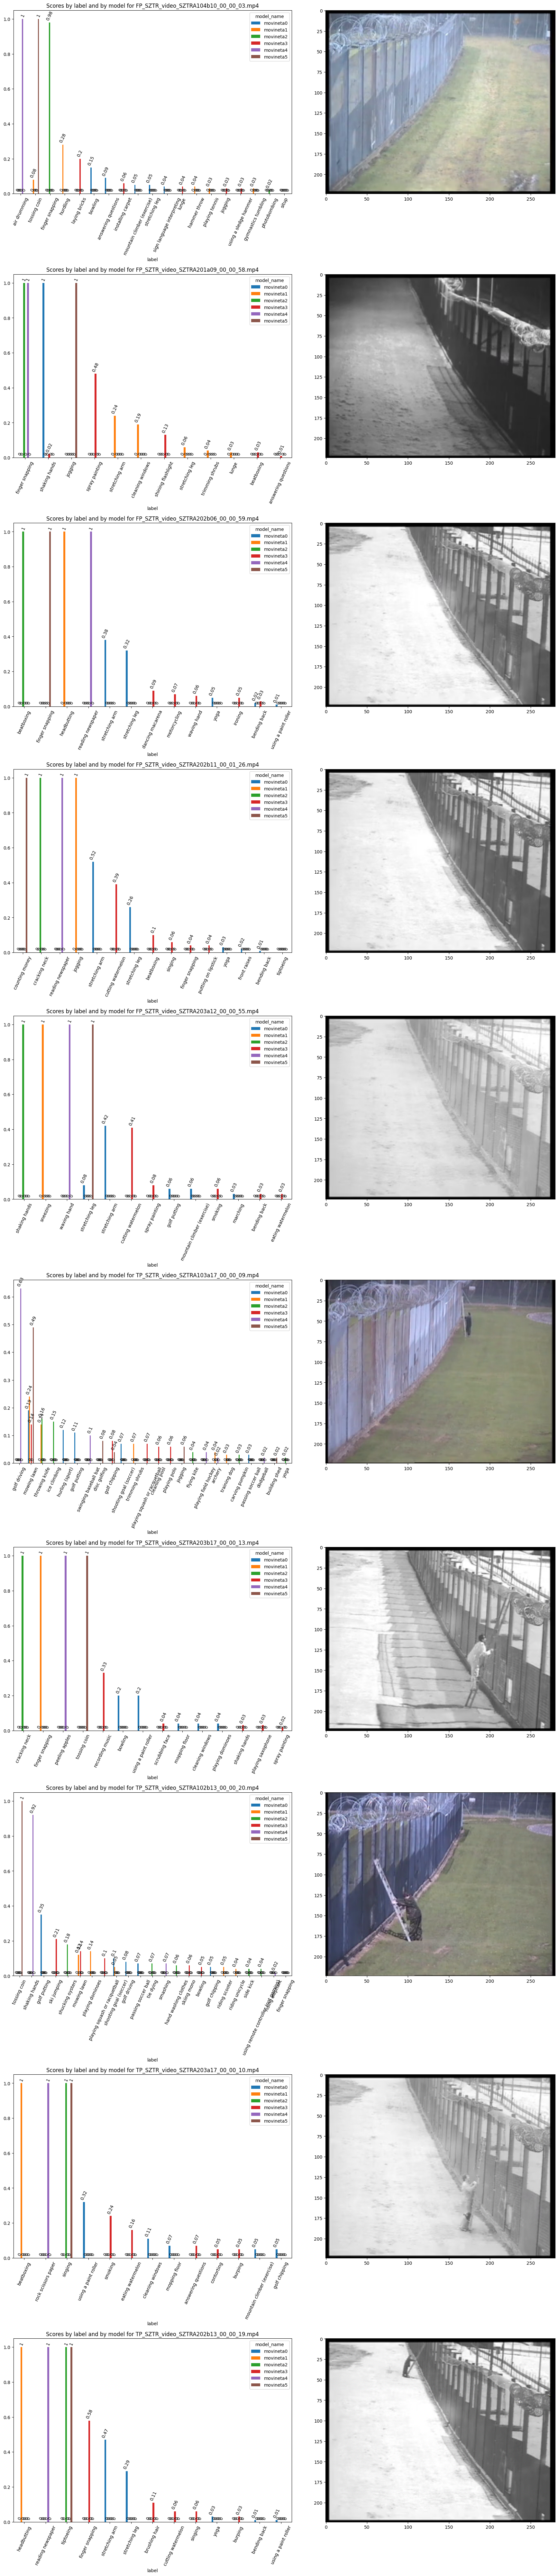

In [86]:
def get_middle_frame(frame: Path):
    vr = VideoReader(str(frame), ctx=cpu(0))
    middle_frame_idx = int(len(vr) / 2)

    frame = vr[middle_frame_idx]

    return Image.fromarray(frame.asnumpy())


# get_middle_frame(Path(df.iloc[0]["path"]))
def plot_score_by_label_model(path: str, axs: List):
    path_df = label_score_df[label_score_df["video"] == path].drop(columns="video")
    pivot_df = path_df.pivot(index="label", columns="model_name", values="score")

    pivot_df["mean"] = pivot_df.mean(axis=1)
    pivot_df["max"] = pivot_df.max(axis=1)

    pivot_df = pivot_df[pivot_df["max"] > 0]

    pivot_df = pivot_df.sort_values(by=["max", "mean"], ascending=False).drop(
        columns=["max", "mean"]
    )

    bar_ax, img_ax = axs

    pivot_df.round(decimals=2).plot(
        kind="bar",
        ax=bar_ax,
        rot=65,
        title=f"Scores by label and by model for {Path(path).name}",
    )
    for container in bar_ax.containers:
        bar_ax.bar_label(container, padding=3, rotation=65)

    img_ax.imshow(get_middle_frame(Path(path)))


fig, axs = plt.subplots(
    len(VIDEOS),
    2,
    figsize=(18, 80),
    constrained_layout=True,
)
for ax_row, video in zip(axs, VIDEOS):
    plot_score_by_label_model(video, ax_row)

plt.show()

In [80]:
softmax = torch.nn.Softmax(dim=0)


def apply_softmax(array: List[float]) -> List[float]:
    return softmax(torch.tensor(array)).numpy().tolist()


softmax_features_df = pd.DataFrame(
    [
        [
            "TP" in classification_entity.path,
            classification_entity.model_name,
            classification_entity.path,
            *apply_softmax(classification_entity.features),
        ]
        for classification_entity in joined_dc
    ],
    columns=(["class", "model_name", "path"] + [i for i in range(600)]),
).sort_values("class", ascending=False)

features_df = pd.DataFrame(
    [
        [
            "TP" in classification_entity.path,
            classification_entity.model_name,
            classification_entity.path,
            *classification_entity.features,
        ]
        for classification_entity in joined_dc
    ],
    columns=(["class", "model_name", "path"] + [i for i in range(600)]),
).sort_values("class", ascending=False)

features_columns_indexes = pd.RangeIndex.from_range(range(600))

In [81]:
tp_df = features_df[softmax_features_df["class"]].drop(columns="class")
softmax_tp_df = softmax_features_df[softmax_features_df["class"]].drop(columns="class")
fp_df = features_df[~features_df["class"]].drop(columns="class")

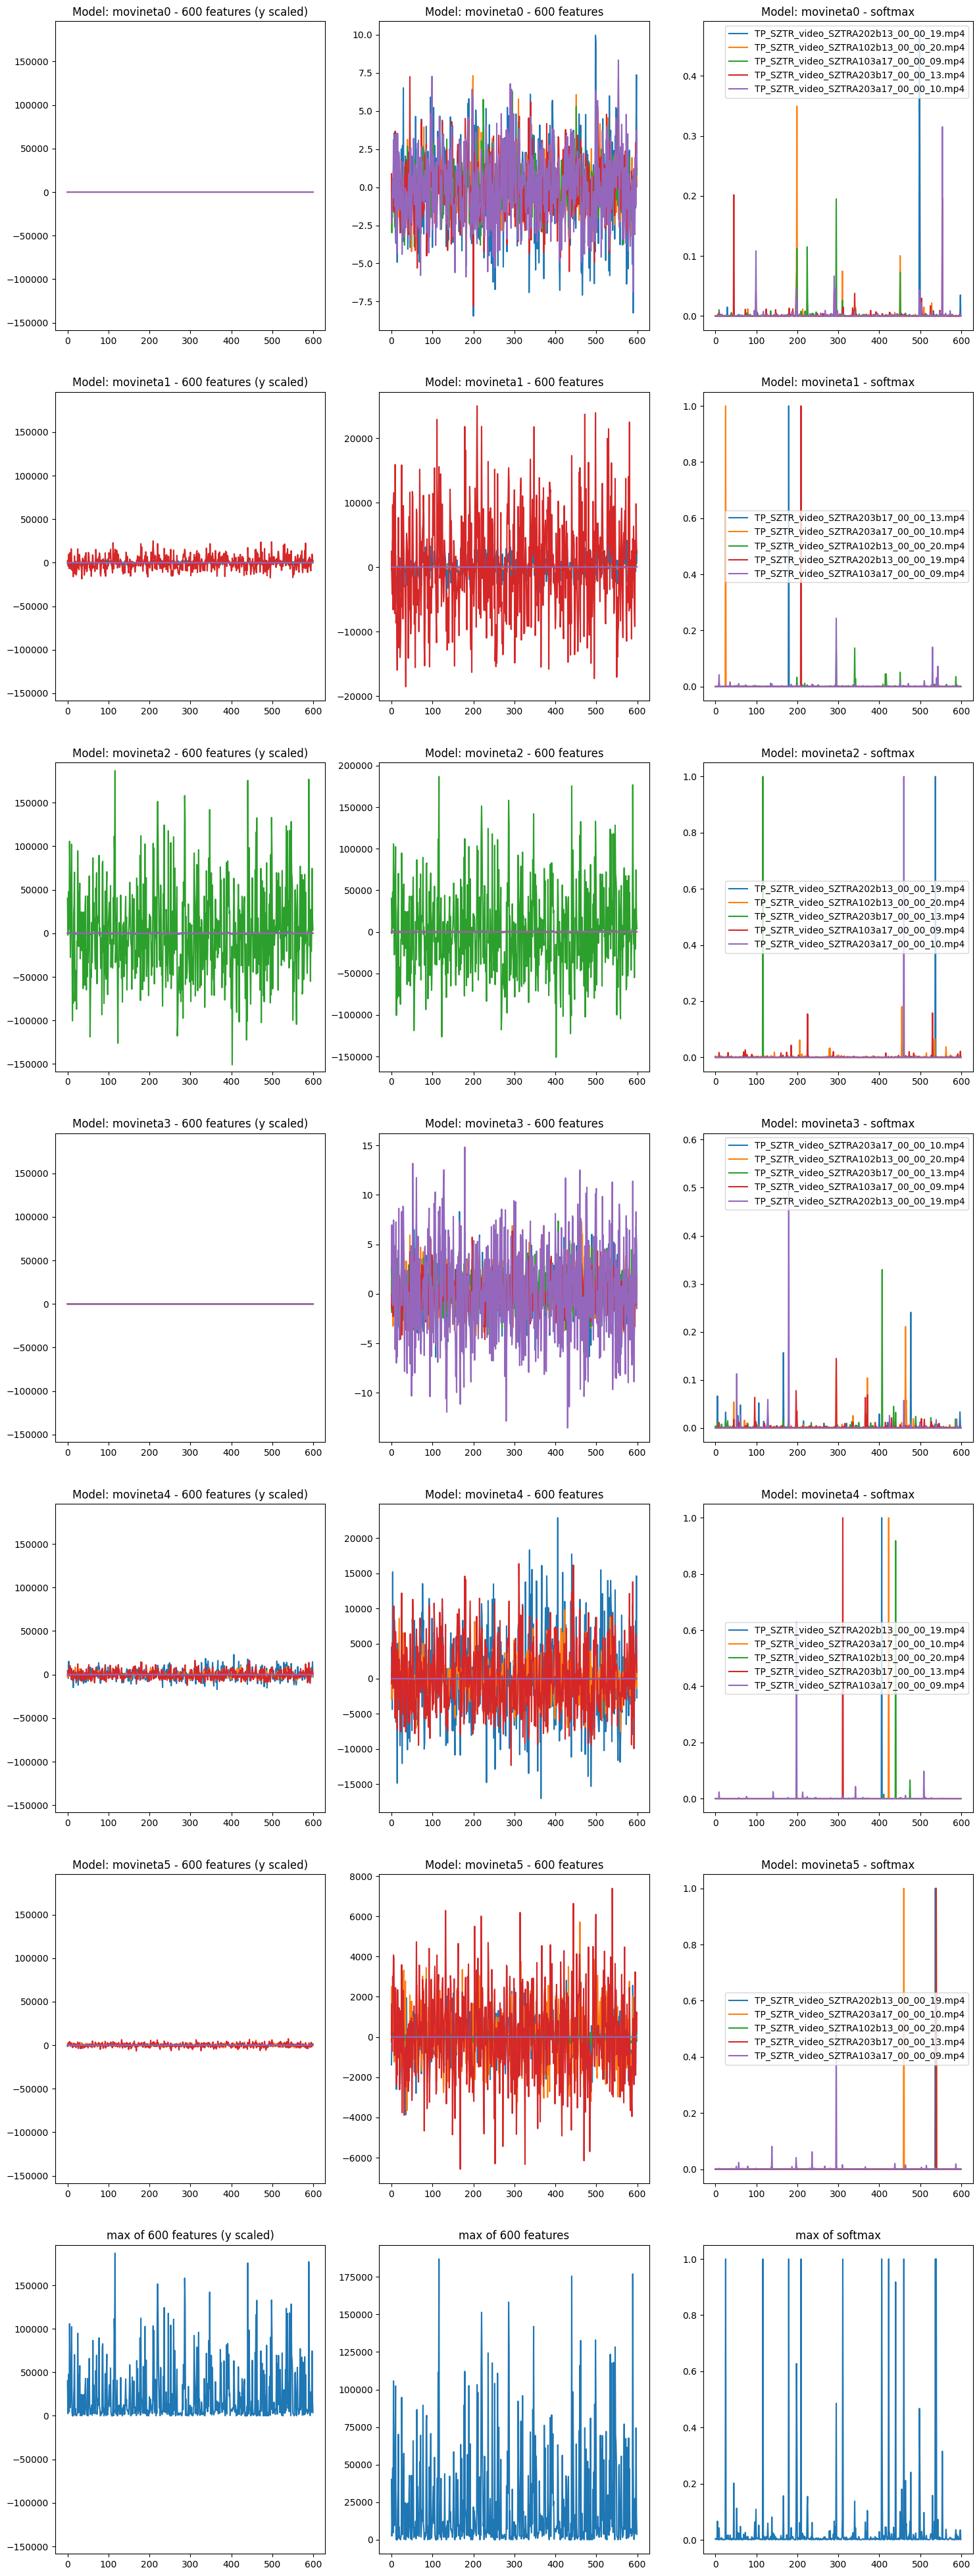

In [82]:
fig, axs = plt.subplots(len(ALL_MOVINET_MODELS) + 1, 3, figsize=(18, 50))

features_only_df = tp_df[features_columns_indexes]

min_y, max_y = features_only_df.min().min(), features_only_df.max().max()

min_y *= 1.05
max_y *= 1.05


def plot_models_amplitude(
    df: pd.DataFrame,
    model_name: str,
    ax,
    title_suffix: str,
    legend: bool = True,
    ylim: Optional[Tuple] = None,
):
    amplitude_df = df[df["model_name"] == model_name].melt(
        ["model_name", "path"], var_name="feature_N", value_name="amplitude"
    )

    def plot_amplitude(path: str):
        path_amplitude_series = (
            amplitude_df[amplitude_df["path"] == path]["amplitude"]
            .rename(str(Path(path).name))
            .reset_index(drop=True)
        )
        assert len(path_amplitude_series) == 600

        path_amplitude_series.plot(kind="line", ax=ax, legend=legend, ylim=ylim)

    for path in amplitude_df["path"].unique():
        plot_amplitude(path)

    ax.set_title(f"Model: {model_name} - {title_suffix}")


for model_name, (ax_left, ax_middle, ax_right) in zip(ALL_MOVINET_MODELS, axs):
    plot_models_amplitude(
        tp_df,
        model_name,
        ax_left,
        "600 features (y scaled)",
        legend=False,
        ylim=(min_y, max_y),
    )
    plot_models_amplitude(tp_df, model_name, ax_middle, "600 features", legend=False)
    plot_models_amplitude(softmax_tp_df, model_name, ax_right, "softmax", legend=True)


last_ax_left, last_ax_middle, last_ax_right = axs[-1][:3]

tp_df[features_columns_indexes].max(axis=0).plot(
    kind="line",
    ax=last_ax_left,
    ylim=(min_y, max_y),
    title="max of 600 features (y scaled)",
)
tp_df[features_columns_indexes].max(axis=0).plot(
    kind="line", ax=last_ax_middle, title="max of 600 features"
)
softmax_tp_df[features_columns_indexes].max(axis=0).plot(
    kind="line", ax=last_ax_right, title="max of softmax"
)

plt.show()

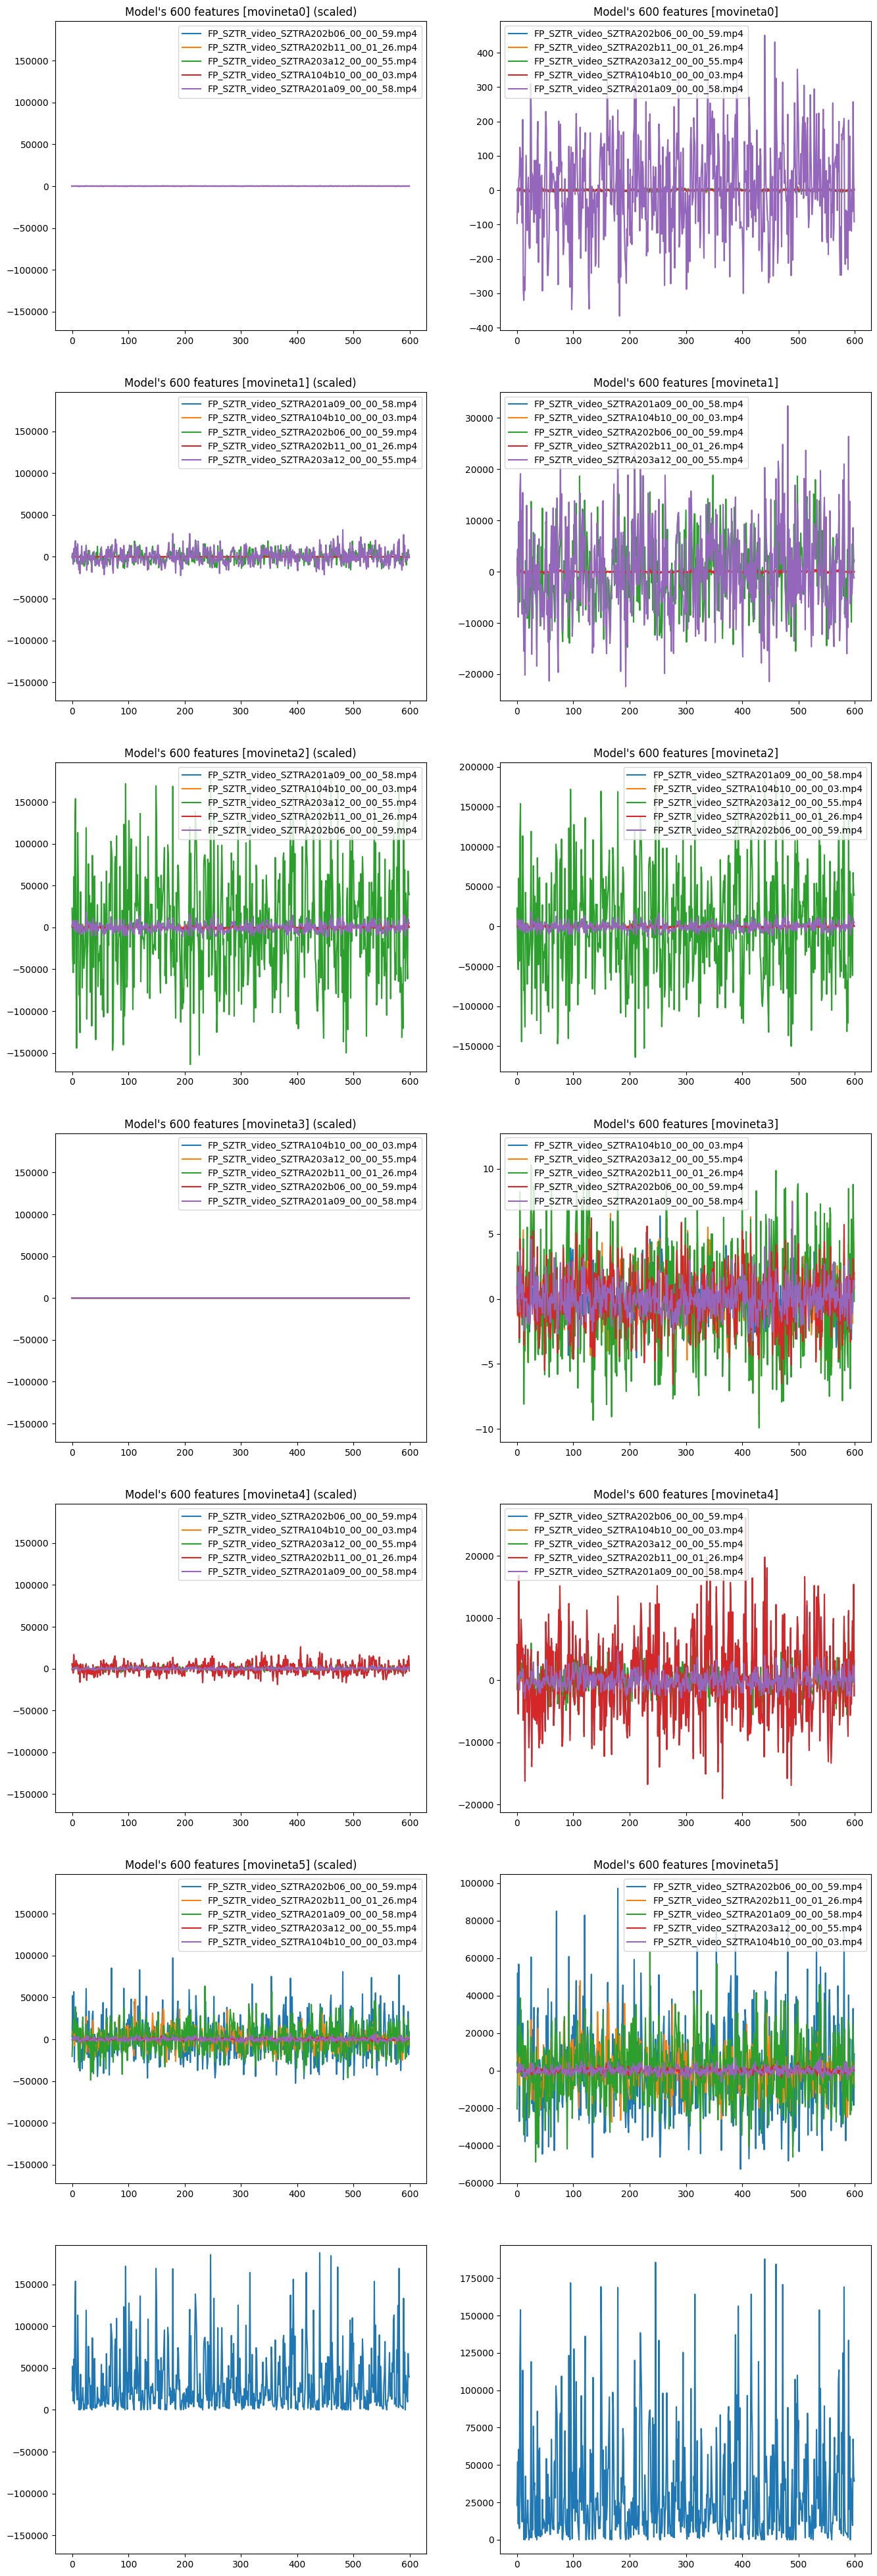

In [83]:
fig, axs = plt.subplots(len(ALL_MOVINET_MODELS) + 1, 2, figsize=(16, 50))

features_only_df = fp_df[features_columns_indexes]

min_y, max_y = features_only_df.min().min(), features_only_df.max().max()

min_y *= 1.05
max_y *= 1.05


def plot_models_amplitude(model_name: str, row_axs):
    amplitude_df = fp_df[fp_df["model_name"] == model_name].melt(
        ["model_name", "path"], var_name="feature_N", value_name="amplitude"
    )

    def plot_amplitude(path: str):
        path_amplitude_series = (
            amplitude_df[amplitude_df["path"] == path]["amplitude"]
            .rename(str(Path(path).name))
            .reset_index(drop=True)
        )
        assert len(path_amplitude_series) == 600

        path_amplitude_series.plot(
            kind="line", ax=row_axs[0], legend=True, ylim=(min_y, max_y)
        )
        path_amplitude_series.plot(kind="line", ax=row_axs[1], legend=True)

    for path in amplitude_df["path"].unique():
        plot_amplitude(path)

    row_axs[0].set_title(f"Model's 600 features [{model_name}] (scaled)")
    row_axs[1].set_title(f"Model's 600 features [{model_name}]")


for model_name, row_axs in zip(ALL_MOVINET_MODELS, axs):
    plot_models_amplitude(model_name, row_axs)

features_only_df.max(axis=0).plot(kind="line", ax=axs[-1][0], ylim=(min_y, max_y))
features_only_df.max(axis=0).plot(kind="line", ax=axs[-1][1])

plt.show()

# Classification / Metrics

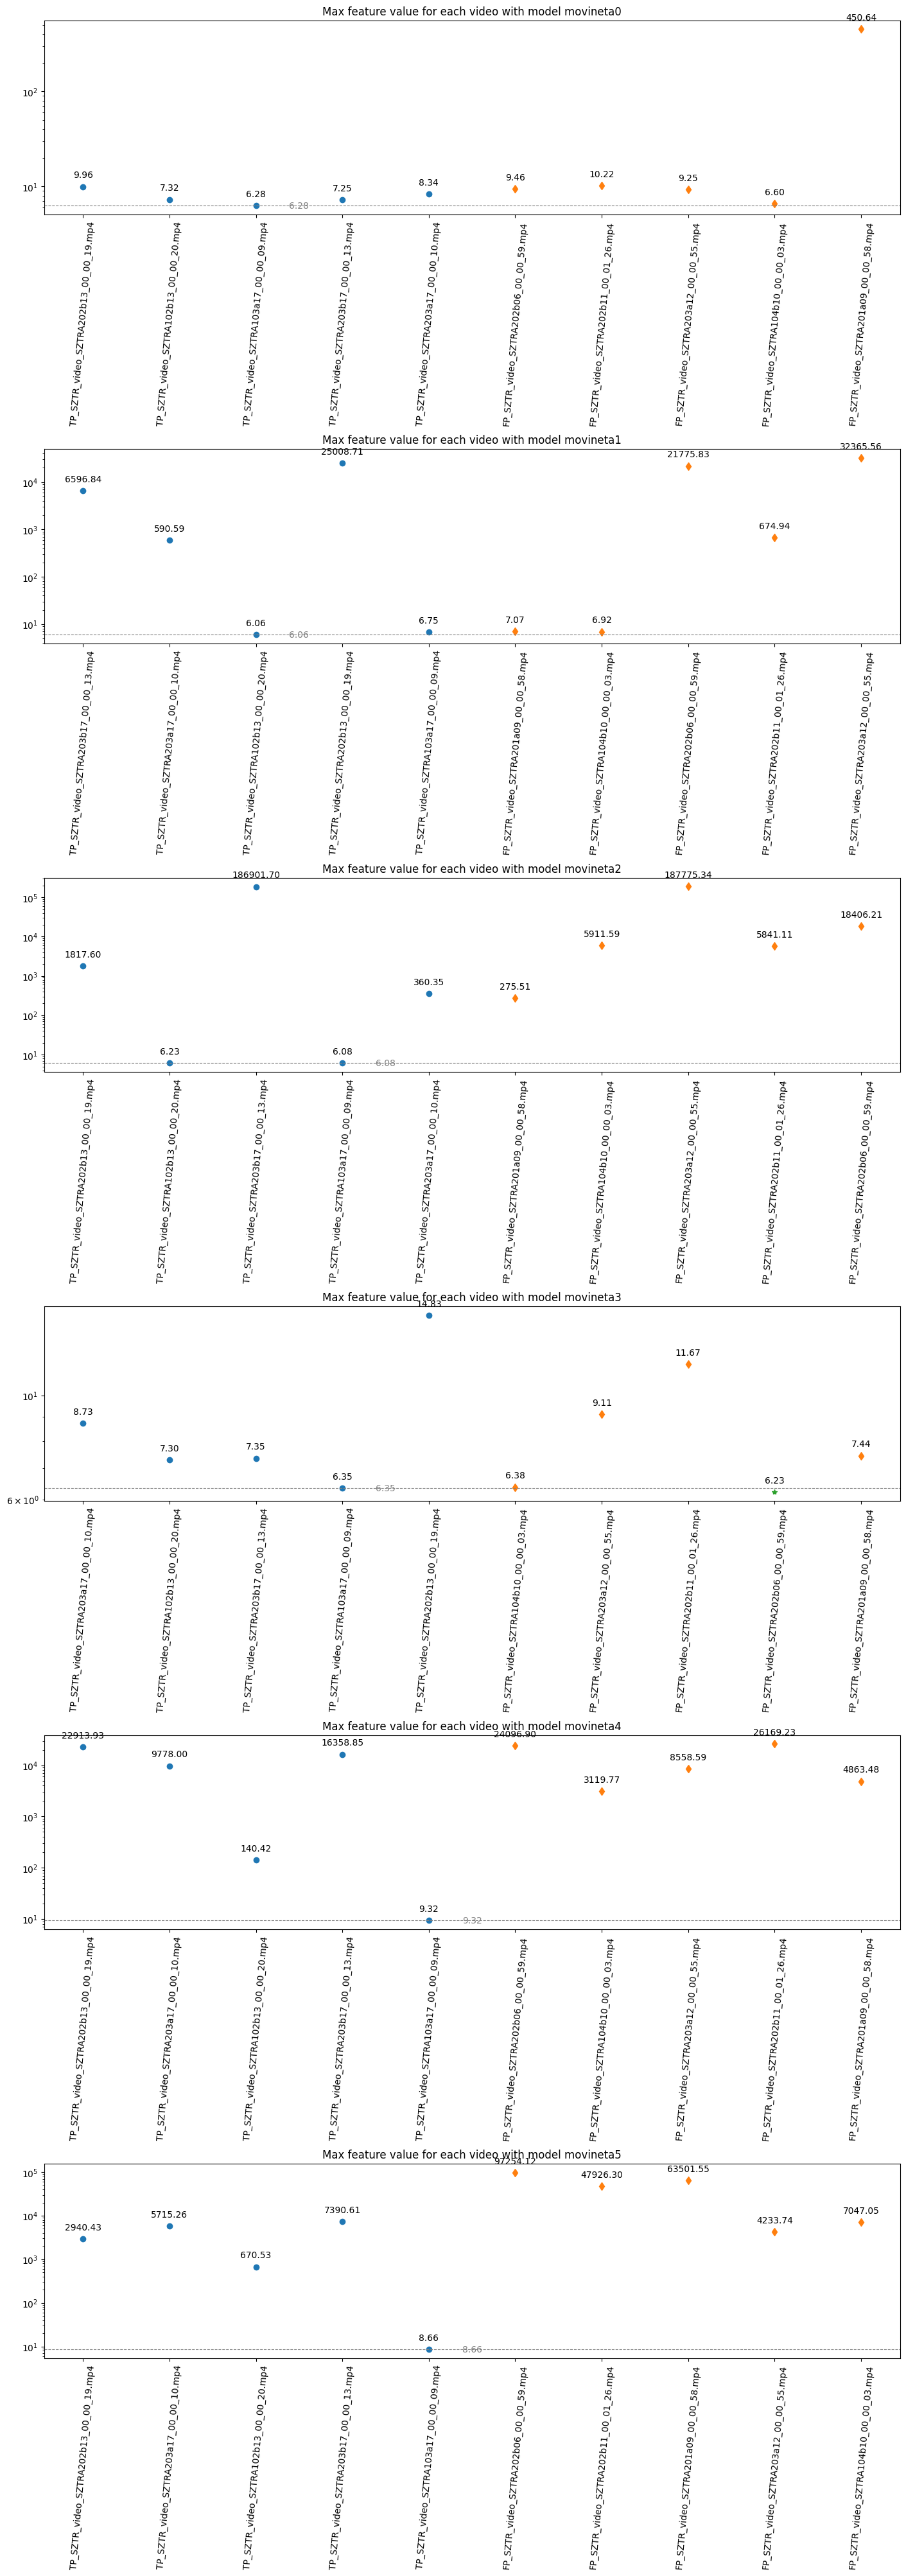

In [84]:
def path_name(p: str) -> str:
    return Path(p).name


def plot_max_tp_fp(model_name: str, ax):
    df = (
        features_df[features_df["model_name"] == model_name]
        .drop(columns=["model_name"])
        .reset_index()
    )

    df["path"] = df["path"].apply(path_name)

    X_filenames = df["path"].to_list()

    tp_df = df[df["class"]]
    Y_tp = tp_df[features_columns_indexes].max(axis=1)
    min_activation_of_tp_index = Y_tp.argmin()
    min_activation_of_tp = Y_tp[min_activation_of_tp_index]

    fp_df = df[~df["class"]]
    Y_fp = fp_df[features_columns_indexes].max(axis=1)
    Y_fp_over_min_activation = Y_fp[Y_fp >= min_activation_of_tp]
    Y_fp_below_min_activation = Y_fp[Y_fp < min_activation_of_tp]

    ax.set_title(f"Max feature value for each video with model {model_name}")

    def plot_with_annotation(X, Y, *args):
        ax.plot(X, Y, *args)

        for x, y in zip(X, Y):
            ax.annotate(
                f"{y:.2f}",
                (x, y),
                textcoords="offset points",  # how to position the text
                xytext=(0, 10),  # distance from text to points (x,y)
                ha="center",
            )

    plot_with_annotation(Y_tp.index, Y_tp, "o")
    plot_with_annotation(Y_fp_over_min_activation.index, Y_fp_over_min_activation, "d")
    plot_with_annotation(
        Y_fp_below_min_activation.index, Y_fp_below_min_activation, "*"
    )

    ax.set_xticks(df.index, X_filenames, rotation=85)
    ax.set_yscale("log")

    ax.axhline(min_activation_of_tp, linewidth=0.8, color="grey", linestyle="--")
    ax.annotate(
        f"{min_activation_of_tp:.2f}",
        (min_activation_of_tp_index + 0.5, min_activation_of_tp),
        color="grey",
        ha="center",
        va="center",
    )


fig, axs = plt.subplots(
    len(ALL_MOVINET_MODELS), 1, figsize=(14, 40), constrained_layout=True
)

for model_name, ax in zip(ALL_MOVINET_MODELS, axs):
    plot_max_tp_fp(model_name, ax)

plt.show()

[0.  0.2 0.2 0.4 0.4 0.8 0.8 1.  1. ]
[0.  0.  0.4 0.4 0.6 0.6 0.8 0.8 1. ]
[15.83 14.83  9.11  8.73  7.44  7.3   6.38  6.35  6.23]
0.52
Threshold value is: 7.3


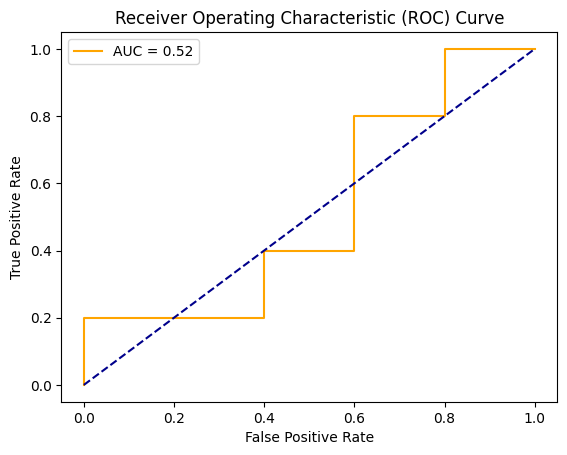

In [106]:
from sklearn.metrics import RocCurveDisplay


def plot_roc_curve(fpr, tpr):
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_score)
    roc_display.plot(color="orange")
    # plt.plot(fpr, tpr, color='orange', label='ROC')
    roc_display.ax_.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    roc_display.ax_.set_title("Receiver Operating Characteristic (ROC) Curve")
    roc_display.ax_.legend()
    plt.show()


y_true = np.array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])
y_scores = np.array([8.73, 7.30, 7.35, 6.35, 14.83, 6.38, 9.11, 11.67, 6.23, 7.44])

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
print(tpr)
print(fpr)
print(thresholds)
auc_score = roc_auc_score(y_true, y_scores)
print(auc_score)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr)

In [116]:
predictions = torch.tensor(
    [8.73, 7.30, 7.35, 6.35, 14.83, 6.38, 9.11, 11.67, 6.23, 7.44]
)
target = torch.tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0])

# fpr, tpr, thresholds = metrics.functional.roc(predictions, target)
# plot_roc_curve(fpr.numpy(), tpr.numpy())
fpr, tpr, thresholds = roc_curve(target.numpy(), predictions.numpy())
# plot_roc_curve(fpr, tpr)
# print(metrics.functional.auc(fpr, tpr))
# print(torch.max(tpr - fpr))

min_threshold = torch.min(predictions[target == 1])

# metrics.functional.auroc(predictions, target, pos_label=1)
confusion = metrics.functional.confusion_matrix(
    predictions, target, num_classes=2, threshold=min_threshold
)
tp, fp, tn, fn, sup = metrics.functional.stat_scores(
    predictions, target, threshold=min_threshold
)

dict(tp=tp, fp=fp, tn=tn, fn=fn, sup=sup, confusion=confusion)

{'tp': tensor(5),
 'fp': tensor(4),
 'tn': tensor(1),
 'fn': tensor(0),
 'sup': tensor(5),
 'confusion': tensor([[1, 4],
         [0, 5]])}